In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster



#### Import compiled_SUPERsnow.nc

In [3]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc'

#ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()

#~~~~~~~~~~~~~~ds small
# dsmall = ds.sel(time='2013')
# dsmall.close()

# ds = dsmall
# ds.close()

#~~~~~~~~~~~ds peak
dpeak = ds.isel(time=[0,7,18,30,42,49]) #0,7,22,28,41,49]
dpeak.close()

ds = dpeak
ds.close()
ds

<xarray.Dataset>
Dimensions:  (time: 6, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) int16 dask.array<shape=(6, 17002, 17569), chunksize=(1, 1000, 1000)>

#### Plotting features:

In [4]:
# legends/labels
d_str = pd.to_datetime(ds['time'].values).strftime("%m-%d-%Y")
print('number of legend labels:', len(d_str))


# fontsize, linewitch, etc.
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

number of legend labels: 6


#### test terrain layers

In [ ]:
# #brake filepath.......
# terrain_path = ''
# flist_terrain = sorted(glob.glob(terrain_path))
# flist_terrain

In [ ]:
# terrain = xr.open_dataset(flist_terrain[0]).rename({'Band1':'aspect'}) #, concat_dim='time', combine='nested', chunks={'x':1000, 'y':1000}, parallel=True)
# terrain

In [ ]:
# plt.imshow(terrain.aspect, cmap='Set2')

#### test dask array

In [ ]:
bigshape = (200000, 4000)
chunk_shape = (1000, 1000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones


In [ ]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

In [ ]:
mu = ds.snow.mean(dim=('x','y'))

with ProgressBar():
    result = mu.compute()
result


#### histogram leftovers...

In [ ]:
# bar plot (you see the rounding gaps from [m] to [mm])
fig=plt.figure(figsize=(10,5))
plt.bar(bx,h, align='edge')
plt.xlim(0,600)

In [ ]:
#fig for one!
fig=plt.figure(figsize=(10,5))
plt.step(bx,h, lw=3, label = d_str[0])
plt.fill_between(bx,h, step="pre", alpha=0.3)
plt.xlim(0,600)
plt.legend()


In [ ]:
def sns_histogram(x):
    ax = sns.distplot(x[x !=0], hist=True, bins=binx)
    return ax


In [ ]:
binx = np.arange(0,2500,2)

with ProgressBar():
    ax = xr.apply_ufunc(sns_histogram, ds.snow[0].values/10, dask='parallelized', output_dtypes=[np.int16])


In [ ]:
with ProgressBar(): #SAVED FIGS FROM HERE
    for i in range(ds.time.size):
        h, bx = xr.apply_ufunc(histogram, ds.snow[i].values/10, dask='parallelized', output_dtypes=[np.float32])
        c_pal = color_palette('q')
        step_hist_plt(h, bx, i, a, c_pal, alpha=0.2, lw=4, shaded=False)

In [ ]:
#### time it
t=time.time()
tt=time.time()
print('runtime =', (tt-t)/60)

In [ ]:
ds

#### one-to-one

In [ ]:
dflat = ds.snow.values.flatten()
# ds.snow.values(dim=('x','y')).flatten()
dflat.size

In [ ]:
# means=airtemps.mean(dim=('lat','lon'))
# ds.Band1.max(dim='time')
# ds.dims
dflat = ds.snow.values(dim='time').flatten()

In [ ]:

# plt.imshow(ds.isel(time=0).snow)
# ds_flat = ds.sel('time').snow.values.flatten().shape



In [ ]:
ds.snow['time'].isel(time=0)

#### one-to-one for ONE

In [7]:
#s1~~~~~~~
s1 = ds.snow[3].values.flatten()
s1_gt_zero = s1 > 0

#s2~~~~~~
s2 = ds.snow[5].values.flatten()
s2_gt_zero = s2 > 0

In [ ]:
print(s1.shape)
print(s2.shape)

Text(0, 0.5, '2018')

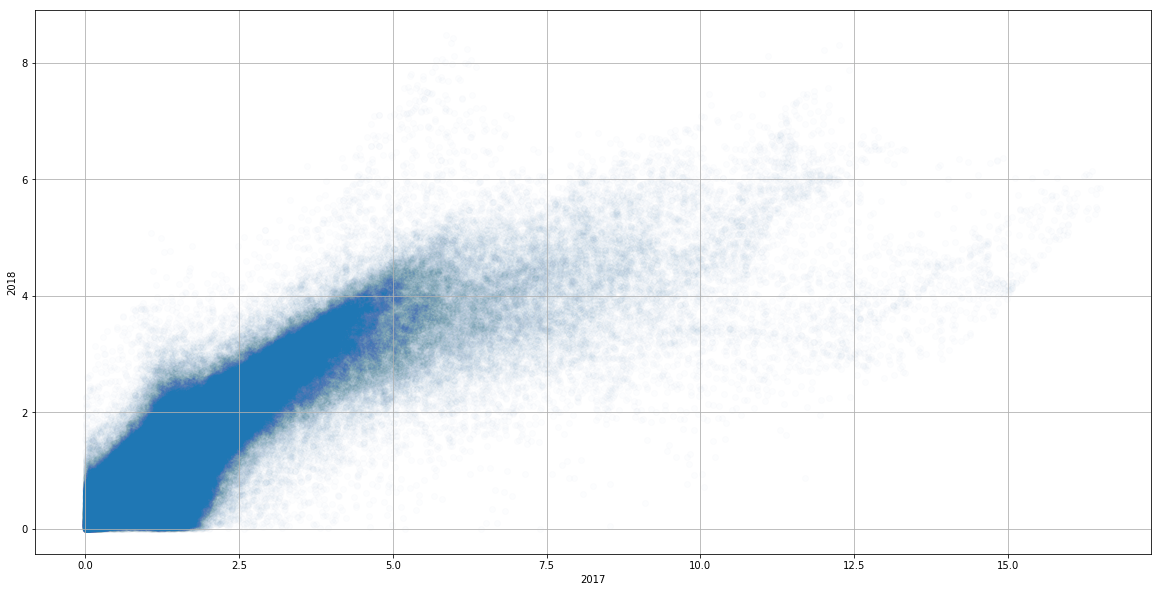

In [8]:
# works for 1
# plotting 1/3 of data (1,000,000)

#template
# ax = plt.scatter(y [ x>0 & y>0 ] / mean( y (y>0) ), x [ x>0 & y>0 ] / mean (x [ x>0 ]) )
plt.figure(figsize=(20,10))

ax = plt.scatter(s2[s1_gt_zero & s2_gt_zero][:1000000] / np.nanmean(s2[s2_gt_zero]),
            s1[s1_gt_zero & s2_gt_zero][:1000000] / np.nanmean(s1[s1_gt_zero]), alpha=0.01) #[:1000000][:1000000]

plt.grid()
plt.xlabel('2017')
plt.ylabel('2018')

In [ ]:
s1.max()


17002


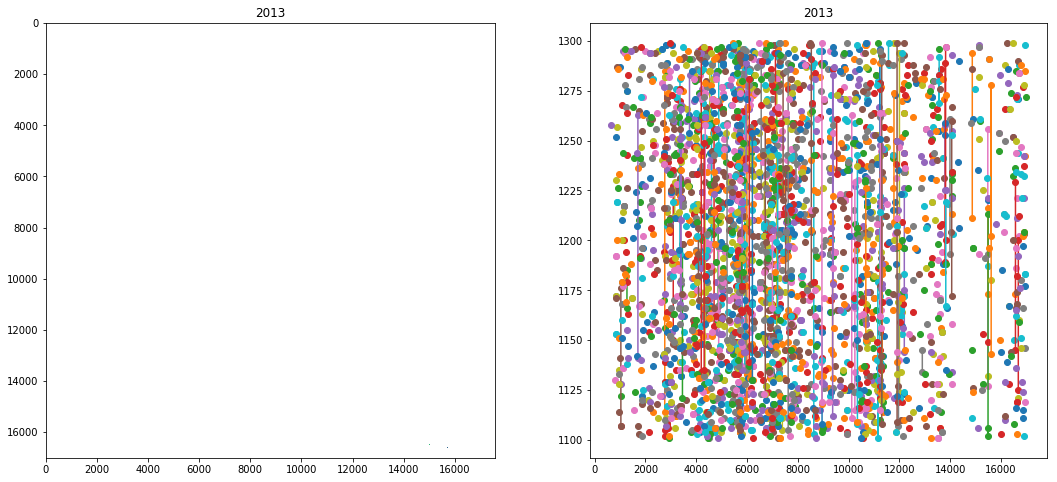

In [12]:
# s1=2013
# s2=2014

#STUFF WITH ERNESTO!

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))

ax1.imshow(ds.snow[0].where(((ds.snow[0]>1100) & (ds.snow[0]<1300)) & (ds.snow[1]>3500) ))
ax1.set_title('2013')

ax2.plot(ds.snow[0].where(((ds.snow[0]>1100) & (ds.snow[0]<1300)) & (ds.snow[1]>3500) ), marker='o')
ax2.set_title('2013')

# ax2.imshow(ds.snow[1].where((ds.snow[1]>3500) & (ds.snow[1]<5000)))
# ax2.set_title('2014')

odd_pixs = ds.snow[0].where(((ds.snow[0]>1100) & (ds.snow[0]<1300)) & (ds.snow[1]>3500))
print(len(odd_pixs))
                                                                       


In [16]:
test_matrix = ((ds.snow[0]>1100) & (ds.snow[0]<1300)) & (ds.snow[1]>3500)


In [39]:
funny_pixels_np = ds.snow[0].values * test_matrix.values

In [42]:
funny_pixels_np.shape


(17002, 17569)

In [52]:
head = "ncols {}\n".format('17569')
head += "nrows {}\n".format('17002')
head += "xllcorner {}\n".format('254005.5')
head += "yllcorner {}\n".format('4179322.5')
head += "cellsize {}\n".format('3.0')
head += "NODATA_value -999"
fpath = '/home/meganmason/Documents/projects/thesis/results/temp/'
np.savetxt(fpath + 'funny_pixels_2013.asc', funny_pixels_np, header=head, fmt='%.0e', comments='')


In [ ]:
numpy.savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='n', header='', footer='', comments='# ', encoding=None)

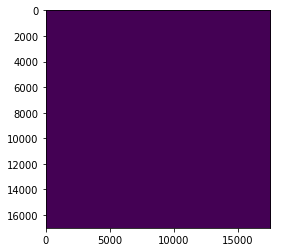

In [17]:
plt.imshow(test_matrix)
plt.show()

In [ ]:
# def one_to_one (lidar_1, lidar_2):
    
# '''flatten lidar'''
#         #lidar 1
#     lidar_1_flat = ds.snow[lidar_1].values.flatten()
#     lidar_1_gt_zero = lidar_1_flat > 0
#         #lidar 2
#     lidar_2_flat = ds.snow[lidar_2].values.flatten()
#     lidar_2_gt_zero = lidar_2_flat > 0
    
# ''''mean w/o zeros''
    
# '''R2 value'''

# '''Scatter plot'''
    
    
def flatten(lidar):
    lidar_flat = ds.snow[lidar].values.flatten()
    lidar_flat_gt_zero = lidar_flat > 0
    
    return lidar_flat, lidar_flat_gt_zero

# def plot_stats():
#     txt_mean = np.nanmean(lidar_flat[lidar_flat_gt_zero])
#     txt_mean_str = txt_mean 
# def one_to_one():
    

In [ ]:
for i in range(ds.time.size):
    #print(ds.snow[i]) #prints each lidar layer
    dp_1, dp_1_gt_zero = flatten(i)
    for i_2 in range(i+1, ds.time.size):
        #print(ds.snow[i_2]) #prints the subsequent lidar layer to use to compare 
        dp_2, dp_2_gt_zero = flatten(i_2)
        break

In [ ]:
dp_1.min()

In [ ]:
#string for ONE date
# d = str(pd.to_datetime(ds['time'][0].values).date())

#pd datetime (index??) for all dates. 
d = pd.to_datetime(ds['time'].values).strftime("%m-%d-%Y")


In [ ]:
d = []
for d in range(ds.time.size):
    print(d)
#     vtimes.append(datetime.utcfromtimestamp(data.time[t].data.astype('O') / 1e9))
    d.append(ds.time[d])
print(d)

In [ ]:
ds.time.size

In [ ]:
# Create matrix with indices
index_matrix = np.zeros((5,5), dtype = int)
k_index = 1
for i_row in range(5):
    for i_column in range(5):
        index_matrix[i_row, i_column] = k_index
        k_index += 1


for i_year in range(4):
    ds.time
        

In [ ]:
# binx = np.arange(0,2500,10) #(start, stop, step by [cm])
# i=0
# with ProgressBar():   
#     h, bx = xr.apply_ufunc(histogram, ds.snow[0].values/10, dask='parallelized', output_dtypes=[np.float32])
#     step_hist_plt(h, bx, i)

#### flatten, make new xarray

In [ ]:
ds

In [ ]:
d = ds.stack(z=('x','y')) # d.indexes['z']

d=d.astype(np.int16, copy=False)

d

In [ ]:
print(d.snow[0].shape)
print(d.snow[1].shape)


In [ ]:
ds.plot.scatter()
# xr.plot.scatter(ds.snow[0], ds.snow[1])